<a id='00-nb'></a>

# Music Recommender

## Overview
----
Welcome of the Music Recommender use-case with Amazon SageMaker. In this series of notebooks we will go through the ML Lifecycle and show how we can build a Music Recommender System using a combination of SageMaker Services and features. IN each phase, we will have relevant notebooks that show you how easy it is to implement that phase of the lifecycle.


----
### Contents
- [Overview](00_overview_arch_data.ipynb)
    - [Architecture](#arch-overview)
    - [Get the Data](#get-the-data)
    - [Update the data sources](#update-data-sources)
    - [Explore the Data](#explore-data)
- [Part 1: Data Prep using Data Wrangler](01_music_dataprep.flow)
- [Part 2a: Feature Store Creation - Tracks](02a_export_fg_tracks.ipynb)
- [Part 2b: Feature Store Creation - User Preferences](02b_export_fg_5star_features.ipynb)
- [Part 2c: Feature Store Creation - Ratings](02c_fg_create_ratings.ipynb)
- [Part 3: Train Model with Debugger Hooks. Set Artifacts and Register Model.](03_train_model_lineage_registry_debugger.ipynb)
- [Part 4: Deploy Model & Inference using Online Feature Store](04_deploy_infer_explain.ipynb)
- [Part 5: Model Monitor](05_model_monitor.ipynb)
- [Part 6: SageMaker Pipelines](06_pipeline.ipynb)

<a id ='arch-overview'></a>

## Architecture

Let's look at the overall solution architecure for this use case. We will start by doing each of these tasks within the exploratoyr phase of the ML Lifecycle, then when we are done with Experimentation and Trials, we can develop an automated pipeline such as the one depicted here to prepare data, deposit in feature store, train and tune the model, deposit it in the registry, then deploy it to a SageMaker hosted endpoint, and run Monitoring on it.

##### [back to top](#00-nb)
----

![Solution Architecure](./images/music-rec.png)

In [1]:
print("Amit")

Amit


In [2]:
import sys
import pprint
sys.path.insert(1, './code')

In [3]:

from parameter_store import ParameterStore
ps = ParameterStore()
parameters = ps.read('music-rec')
pprint.pprint(parameters)


Loading : 



NameError: name 'parameters' is not defined

In [ ]:
# update pandas to avoid data type issues in older 1.0 version
!pip install pandas --upgrade --quiet
import pandas as pd
print(pd.__version__)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import sagemaker 
import boto3
import os
from awscli.customizations.s3.utils import split_s3_bucket_key

# Sagemaker session
sess = sagemaker.Session()
# get session bucket name
bucket = sess.default_bucket()
# bucket prefix or the subfolder for everything we produce
prefix='music-recommendation'

ps.add({'bucket': bucket, 'prefix': prefix}, namespace='music-rec')

# s3 client
s3_client = boto3.client("s3")

print(f"this is your default SageMaker Studio bucket name: {bucket}")  

Creating : 

{'bucket': 'sagemaker-us-west-2-738335684114', 'prefix': 'music-recommendation'}
Adding new Params : 

{'bucket': 'sagemaker-us-west-2-738335684114', 'prefix': 'music-recommendation'}
this is your default SageMaker Studio bucket name: sagemaker-us-west-2-738335684114


In [4]:
parameters = ps.read('music-rec')
parameters

<class 'AttributeError'>
("'ParameterStore' object has no attribute 'namespace'",)
'ParameterStore' object has no attribute 'namespace'


In [5]:
def get_data(public_s3_data, to_bucket):
    new_paths = []
    for f in public_s3_data:
        bucket_name, key_name = split_s3_bucket_key(f)
        filename = f.split('/')[-1]
        new_path = "s3://{}/{}/{}".format(to_bucket, prefix, filename)
        new_paths.append(new_path)
        
        # only download if not already downloaded
        if not os.path.exists('./{}'.format(filename)):
            # download s3 data
            print("Downloading file from {}".format(f))
            s3_client.download_file(bucket_name, key_name, './{}'.format(filename))

        # upload s3 data to our default s3 bucket for SageMaker Studio
        print("Uploading {} to {}\n".format(filename, new_path))
        s3_client.upload_file('./{}'.format(filename), to_bucket, os.path.join(prefix,filename))
        
    return new_paths


def get_model(model_path, to_bucket):
    # upload model to our default s3 bucket for SageMaker Studio
    filename = model_path.split('/')[-1]
    print("Uploading {} to {}\n".format(model_path, os.path.join(to_bucket,prefix,filename)))
    s3_client.upload_file(model_path, to_bucket, os.path.join(prefix,filename))
    return "s://{}".format(os.path.join(to_bucket,prefix,filename))
        

def update_data_sources(flow_path, tracks_data_source, ratings_data_source):
    with open(flow_path) as flowf:
        flow = json.load(flowf)
        
    for node in flow['nodes']:
        # if the key exists for our s3 endpoint
        try:
            if node['parameters']['dataset_definition']['name'] == 'tracks.csv':
                # reset the s3 data source for tracks data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, tracks_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = tracks_data_source
            elif node['parameters']['dataset_definition']['name'] == 'ratings.csv':
                # reset the s3 data source for ratings data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, ratings_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = ratings_data_source
        except:
            continue
    # write out the updated json flow file
    with open(flow_path, 'w') as outfile:
        json.dump(flow, outfile)
    
    return flow

<a id='get-the-data'></a>

## Prereqs: Get Data 
##### [back to top](#00-nb)
----

Here we will download the music data from a public S3 bucket that we'll be using for this demo and uploads it to your default S3 bucket that was created for you when you initially created a SageMaker Studio workspace. 

In [6]:
# public S3 bucket that contains our music data
s3_bucket_music_data = "s3://sagemaker-sample-files/datasets/tabular/synthetic-music"

In [7]:
new_data_paths = get_data([f"{s3_bucket_music_data}/tracks.csv", f"{s3_bucket_music_data}/ratings.csv"], bucket)
print(new_data_paths)

Uploading tracks.csv to s3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv

Uploading ratings.csv to s3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv

['s3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv', 's3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv']


In [8]:
# these are the new file paths located on your SageMaker Studio default s3 storage bucket
tracks_data_source = f's3://{bucket}/{prefix}/tracks.csv'
ratings_data_source = f's3://{bucket}/{prefix}/ratings.csv'

ps.add({'tracks_data_source': tracks_data_source, 'ratings_data_source': ratings_data_source}, namespace='music-rec')


Updating Params : 

{'ratings_data_source': 's3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv',
 'tracks_data_source': 's3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv'}


### Upload pretrained model

In [9]:
model_path = get_model('./model/model.tar.gz', bucket)

ps.add({'model_path': model_path}, namespace='music-rec')


Uploading ./model/model.tar.gz to sagemaker-us-west-2-738335684114/music-recommendation/model.tar.gz

Updating Params : 

{'model_path': 's://sagemaker-us-west-2-738335684114/music-recommendation/model.tar.gz'}


<a id='update-data-sources'></a>

## Update the data source in the `.flow` file
##### [back to top](#00-nb)
----
The `01_music_datapred.flow` file is a JSON file containing instructions for where to find your data sources and how to transform the data. We'll be updating the object telling Data Wrangler where to find the input data on S3. We will set this to your default S3 bucket. With this update to the `.flow` file it now points to your new S3 bucket as the data source used by SageMaker Data Wrangler.

Make sure the `.flow` file is closed before running this next step or it won't update the new s3 file locations in the file

In [10]:
update_data_sources('01_music_dataprep.flow', tracks_data_source, ratings_data_source)

Changed s3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv to s3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv
Changed s3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv to s3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv


{'metadata': {'version': 1, 'disable_limits': False},
 'nodes': [{'node_id': '99823cc7-ddf7-4660-a279-efe1ab225ade',
   'type': 'SOURCE',
   'operator': 'sagemaker.s3_source_0.1',
   'parameters': {'dataset_definition': {'__typename': 'S3CreateDatasetDefinitionOutput',
     'datasetSourceType': 'S3',
     'name': 'tracks.csv',
     'description': None,
     's3ExecutionContext': {'__typename': 'S3ExecutionContext',
      's3Uri': 's3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv',
      's3ContentType': 'csv',
      's3HasHeader': True}}},
   'inputs': [],
   'outputs': [{'name': 'default',
     'sampling': {'sampling_method': 'sample_by_limit',
      'limit_rows': 50000}}]},
  {'node_id': '892bbc66-6a4e-459e-b659-40e386600927',
   'type': 'TRANSFORM',
   'operator': 'sagemaker.spark.infer_and_cast_type_0.1',
   'parameters': {},
   'trained_parameters': {'schema': {'trackId': 'string',
     'length': 'float',
     'energy': 'float',
     'acousticness': 'float',
 

<a id='explore-data'></a>

## Explore the Data
##### [back to top](#00-nb)
----

In [11]:
tracks = pd.read_csv('./tracks.csv')
ratings = pd.read_csv('./ratings.csv')

In [12]:
tracks.head()

,trackId,length,energy,acousticness,valence,speechiness,instrumentalness,liveness,tempo,genre
0,d52745ac-05f2-4d51-be51-62e7fbbed61c,383.0,0.882559,0.077348,0.834408,0.118940,0.054557,0.037616,170.164645,Pop_Rock
1,f9e37639-64fd-4e2c-97c2-13649df58868,179.0,0.555357,0.494803,0.699073,0.053292,0.000000,0.224911,119.618149,RnB
2,f8348ab0-e356-4bc0-b7d4-8704ae2d7c76,166.0,0.420066,0.769902,0.198496,0.022800,0.814083,0.118941,111.729093,Reggae
3,aa263491-70d5-4029-8e2a-6c43a4260c7a,214.0,0.390868,0.039935,0.701946,0.022800,0.043960,0.155141,119.848188,Electronic
4,eb357cca-4fd6-4d17-98e4-c210956807e9,48.0,0.277757,0.705137,0.037227,0.045960,0.570176,0.097591,101.396837,Folk


In [13]:
ratings.head()

,ratingEventId,ts,userId,trackId,sessionId,itemInSession,Rating
0,a2cfe1df-07d6-4a02-b425-450416133fe5,1572259532,11001,d52745ac-05f2-4d51-be51-62e7fbbed61c,464,31,5.0
1,50720dd3-ce99-4ddb-858a-88ba934a6293,1572259915,11001,f9e37639-64fd-4e2c-97c2-13649df58868,464,33,3.0
2,60a2ca19-d011-4cb8-ab8b-e9034adb4ed4,1572260094,11001,f8348ab0-e356-4bc0-b7d4-8704ae2d7c76,464,34,1.0
3,d1cc85da-7230-41ef-9e08-4507d86844ba,1572260260,11001,aa263491-70d5-4029-8e2a-6c43a4260c7a,464,35,5.0
4,3013f369-5e32-4745-984a-833c34193cc9,1572260474,11001,eb357cca-4fd6-4d17-98e4-c210956807e9,464,36,1.0


In [14]:
print("{:,} different songs/tracks".format(tracks['trackId'].nunique()))
print("{:,} users".format(ratings['userId'].nunique()))
print("{:,} user rating events".format(ratings['ratingEventId'].nunique()))

200,000 different songs/tracks
258 users
1,000,000 user rating events


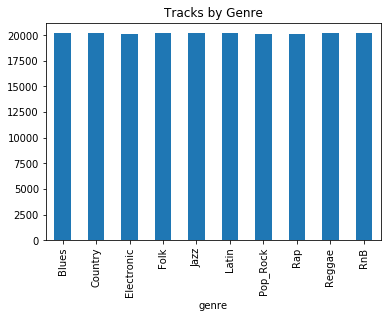

In [15]:
tracks.groupby('genre')['genre'].count().plot.bar(title="Tracks by Genre");

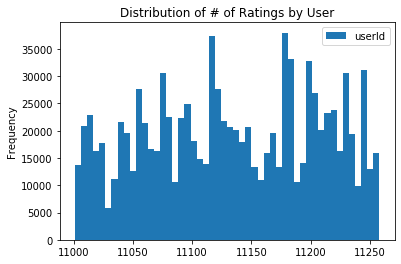

In [16]:
ratings[['ratingEventId','userId']].plot.hist(by='userId', bins=50, title="Distribution of # of Ratings by User");

In [17]:
params = ps.read('music-rec')

<class 'AttributeError'>
("'ParameterStore' object has no attribute 'namespace'",)
'ParameterStore' object has no attribute 'namespace'


In [18]:
ps.store()

Storing : 

{'music-rec': {'bucket': 'sagemaker-us-west-2-738335684114',
               'model_path': 's://sagemaker-us-west-2-738335684114/music-recommendation/model.tar.gz',
               'prefix': 'music-recommendation',
               'ratings_data_source': 's3://sagemaker-us-west-2-738335684114/music-recommendation/ratings.csv',
               'tracks_data_source': 's3://sagemaker-us-west-2-738335684114/music-recommendation/tracks.csv'}}
